In [1]:
!pip install matplotlib
!pip install numpy
!pip install scipy

/var/folders/0m/ws745_6n2cvfd23lmr16wlrw0000gn/T/ipykernel_35196/3078044455.py:23: RuntimeWarning: overflow encountered in cdouble_scalars
  z = z ** 2 + point
/var/folders/0m/ws745_6n2cvfd23lmr16wlrw0000gn/T/ipykernel_35196/3078044455.py:23: RuntimeWarning: invalid value encountered in cdouble_scalars
  z = z ** 2 + point


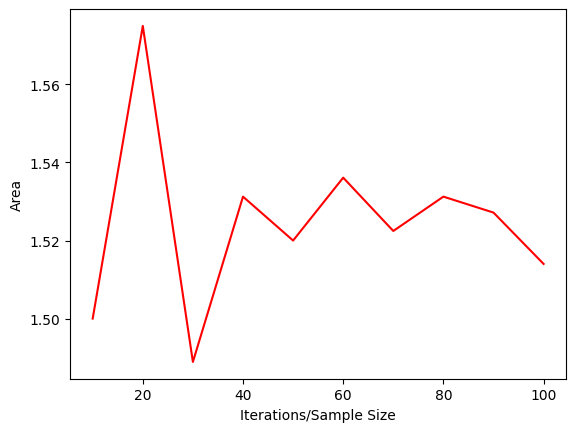

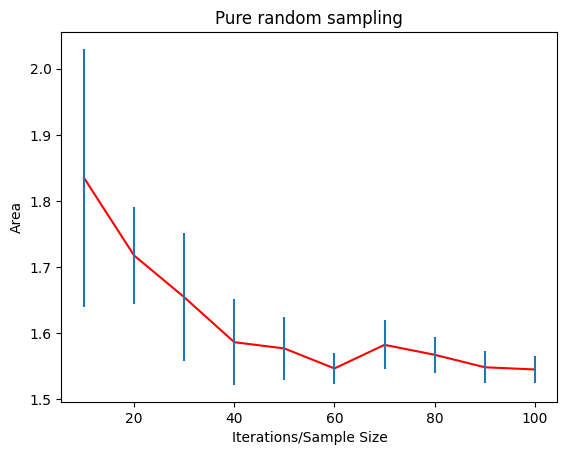

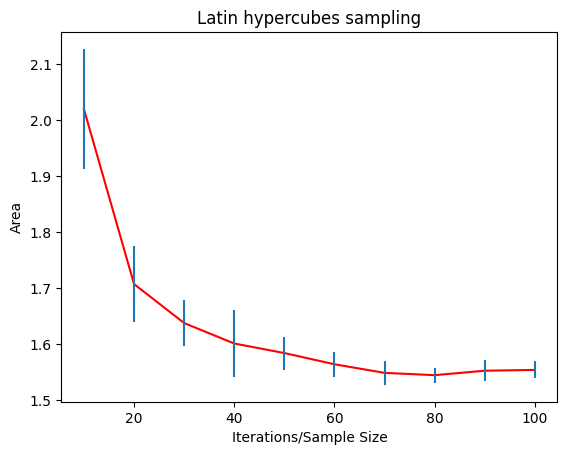

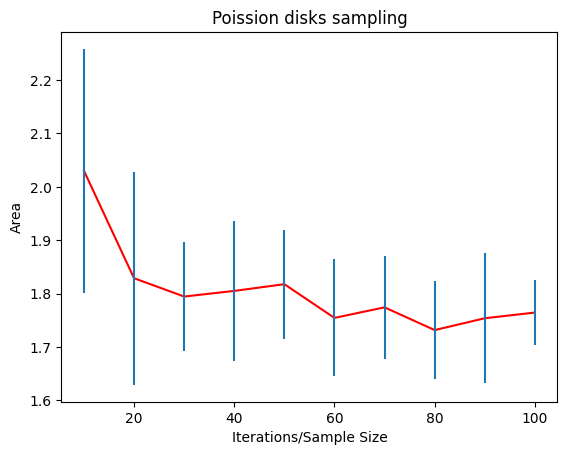

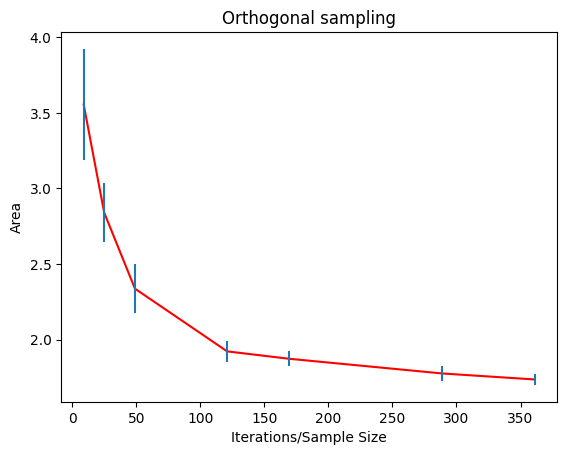

In [18]:
"""
Assignment 1 - Mandelbrot
Dennis Curti: 14526263
Sjoerd Dronkers: 13420607
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats.qmc as qmc
import math 

X_MIN = -2
X_MAX = 0.5
Y_MIN = -1
Y_MAX = 1

def mandelbrot_point(point, iterations):
    """
    Check if a point is in Mandelbrot set.
    """
    z = complex(0)
    for i in range(iterations):
        z = z ** 2 + point
    return abs(z) <= 2

def mandelbrot_sample(sample, iterations):
    """
    Implementation of the Mandelbrot set for one sample
    """
    n = len(sample)
    m = len(sample[0])

    result = np.zeros((n,m), dtype=bool)
    
    for i in range(0,n):
        for j in range(0,m):
            result[i][j] = mandelbrot_point(sample[i][j], iterations)
    
    return result 
    
def mandelbrot(samples, iterations):
    """
    Implementation of the Mandelbrot set for many samples
    """
    results_experiments = []
    
    for sample in samples:
        results_experiments.append(mandelbrot_sample(sample, iterations))
        
    return results_experiments
    
def points(sample_size) -> list:
    """
    Generates all the points needed.
    """
    x_min = -2
    x_max = 0.5
    y_min = -1
    y_max = 1
    return (np.linspace(x_min, x_max, sample_size)[np.newaxis,:]
        + np.linspace(y_min, y_max, sample_size)[:,np.newaxis] * 1j)

def convert_sample_to_complex(sample, sample_size) -> list:
    complex_numbers = np.zeros(shape=(sample_size, sample_size), dtype=np.complex_)
    counter = 0;
    
    for i in range(0, sample_size):
        for j in range(0, sample_size):
            point = sample[i*sample_size + j]
            complex_number = point[0] + point[1] * 1j
            complex_numbers[i][j] = complex_number
    
    return complex_numbers;    
    
def points_random(sample_size) -> list:
    points_generated = np.zeros(shape=(sample_size, sample_size), dtype=np.complex_)
    
    for i in range (0,sample_size):
        for j in range (0,sample_size):
            real = np.random.uniform(X_MIN, X_MAX)
            imaginary = np.random.uniform(Y_MIN, Y_MAX) * 1j
            complex_nr = real + imaginary
            points_generated[i][j] = complex_nr
    
    return points_generated

def scale_samples(sample) -> list:
    for point in sample: 
        point[0] = (X_MAX - X_MIN) * point[0] + X_MIN
        point[1] = (Y_MAX - Y_MIN) * point[1] + Y_MIN
    
    return sample

def points_latin_hypercube(sample_size) -> list:
    sampler = qmc.LatinHypercube(d=2, strength=1)
    sample = sampler.random(n=(sample_size * sample_size))
    sample = scale_samples(sample)
    points_generated = convert_sample_to_complex(sample, sample_size)
    return points_generated;

def points_orthogonal(sample_size) -> list:
    sampler = qmc.LatinHypercube(d=2, strength=2)
    sample = sampler.random(n=sample_size * sample_size)
    sample = scale_samples(sample)
    
    points_generated = convert_sample_to_complex(sample, sample_size)
    return points_generated;

def points_Poisson_disk(sample_size) ->list:
    rng = np.random.default_rng()
    radius = math.sqrt(1.6 / (3.14 * sample_size * sample_size))
    engine = qmc.PoissonDisk(d=2, radius=radius, seed=rng)
    sample = engine.random(sample_size * sample_size)
    sample = scale_samples(sample)
    
    points_generated = convert_sample_to_complex(sample, sample_size)
    return points_generated

def plot_image() -> None:
    complex_plane = np.array(points(1000))
    
    extent = -2, 0.5, -1, 1
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(mandelbrot(complex_plane, 1), cmap='Greens', extent=extent)
    im2 = plt.imshow(mandelbrot(complex_plane, 10), cmap='Reds', alpha=0.6,  extent=extent)
    im3 = plt.imshow(mandelbrot(complex_plane, 100), cmap='Blues', alpha=0.8, extent=extent)
    plt.show()

def sum_trues(bool_matrix) -> int:
    n = len(bool_matrix)
    m = len(bool_matrix[0])
    ans = 0
    
    for i in range(0,n):
        for j in range(0,m):
            if(bool_matrix[i][j]):
                ans = ans + 1
                
    return ans
         
def plot_results(results, xs, title) -> None:
    fig, ax = plt.subplots()
    means = []
    stds = []
    counter = 0
    
    for result in results:
        mean = np.mean(result)
        std = np.std(result)
        means.append(mean)
        stds.append(std)
    
    ax.set_title(title)
    ax.plot(xs, means, color='red')
    ax.errorbar(xs, means, stds, linestyle='None')
    ax.set(xlabel = "Iterations/Sample Size", ylabel = "Area")

def compute_areas(values):
    nr_samples = len(values)
    areas = []
  
    for i in range(0,nr_samples):
        n = len(values[i])
        m = len(values[i][0])
    
        nr_values = n * m
        
        area = sum_trues(values[i]) / nr_values * 5 # 5 is the total area -> change to not hard coded
        areas.append(area)
        
    return areas

def solve_deterministic(iterations, sample_size, nr_samples) -> int:
    """
    Calculates all the points that belong to the Mandelbrot set and calculates
    the area of the Mandelbrot set. Deterministic sampling of points.
    """
    samples = []
    for i in range(0, nr_samples):
        samples.append(points(sample_size))
        
    values = mandelbrot(samples, iterations)
    return compute_areas(values)

def solve_random(iterations, sample_size, nr_samples) -> int:
    """
    Calculates all the points that belong to the Mandelbrot set and calculates
    the area of the Mandelbrot set. Random sampling of points.
    """
    samples = []
    for i in range(0, nr_samples):
        samples.append(points_random(sample_size))
    
    values = mandelbrot(samples, iterations)
    return compute_areas(values)

def solve_latin_hypercube(iterations, sample_size, nr_samples) -> int:
    """
    Calculates all the points that belong to the Mandelbrot set and calculates
    the area of the Mandelbrot set. Latin hypercube sampling of points.
    """
    samples = []
    for i in range(0, nr_samples):
        samples.append(points_latin_hypercube(sample_size))
        
    values = mandelbrot(samples, iterations)
    return compute_areas(values)

def solve_orthogonal(iterations, sample_size, nr_samples) -> int:
    """
    Calculates all the points that belong to the Mandelbrot set and calculates
    the area of the Mandelbrot set. Orthogonal sampling of points.
    """
    samples = []
    for i in range(0, nr_samples):
        samples.append(points_orthogonal(sample_size))
        
    values = mandelbrot(samples, iterations)
    return compute_areas(values)

def solve_Poisson_disk(iterations, sample_size, nr_samples) -> int:
    """
    Calculates all the points that belong to the Mandelbrot set and calculates
    the area of the Mandelbrot set. Orthogonal sampling of points.
    """
    samples = []
    for i in range(0, nr_samples):
        samples.append(points_Poisson_disk(sample_size))
        
    values = mandelbrot(samples, iterations)
    return compute_areas(values)

def mandelbrot_analysis(iterations, sample_size, nr_samples):
    results_deterministic = list()
    
    # Deterministic Mandelbot set for many iteration and sample size values
    for size in sample_size:
        for iter in iterations:
            result = solve_deterministic(iter,size, nr_samples)
            results_deterministic.append(result)
    
    results_random = list()
    
    # Random Mandelbot set for many iteration and sample size values
    for size in sample_size:
        for iter in iterations:
            result = solve_random(iter,size, nr_samples)
            results_random.append(result)
            
    results_latin_hypercube = list()
    
    # Latin Hypercube Mandelbot set for many iteration and sample size values
    for size in sample_size:
        for iter in iterations:
            result = solve_latin_hypercube(iter,size, nr_samples)
            results_latin_hypercube.append(result)
    
    results_orthogonal = list()
    
    # Orthogonal Mandelbot set for many iteration and sample size values
    for size in sample_size:
        for iter in iterations:   
            result = solve_orthogonal(iter,size, nr_samples)
            results_orthogonal.append(solve_latin_hypercube(iter, size))
    
    return (results_deterministic, results_random, results_latin_hypercube, results_orthogonal)
    
def do_all_plots():
    results = []
    nr_samples = 10
    iterations_and_sample_size = np.linspace(10, 100, 10)
    
    deterministics = []
    randoms = []
    latin_hypercubes = []
    orthogonals = []
    Poisson_disks = []
    
    for parameter in iterations_and_sample_size:
        deterministic = solve_deterministic(int(parameter), int(parameter), nr_samples)
        deterministics.append(deterministic)
        
        random = solve_random(int(parameter), int(parameter), nr_samples)
        randoms.append(random)
        
        latin_hypercube = solve_latin_hypercube(int(parameter), int(parameter), nr_samples)
        latin_hypercubes.append(latin_hypercube)
        
        Poisson_disk = solve_Poisson_disk(int(parameter), int(parameter), nr_samples)
        Poisson_disks.append(Poisson_disk)
    
    fig, ax = plt.subplots()
    
    means = []
    
    for deterministic in deterministics:
        mean = np.mean(deterministic)
        means.append(mean)

    ax.plot(iterations_and_sample_size, means, color="red")
    ax.set(xlabel = "Iterations/Sample Size", ylabel = "Area")
    
    plot_results(randoms, iterations_and_sample_size, "Pure random sampling")
    plot_results(latin_hypercubes, iterations_and_sample_size, "Latin hypercubes sampling")
    plot_results(Poisson_disks, iterations_and_sample_size, "Poission disks sampling")
        
    iterations_and_sample_size = np.array([3,5,7,11,13,17,19])
    
    orthogonals = []
    
    for parameter in iterations_and_sample_size:
        orthogonal = solve_orthogonal(int(parameter), int(parameter), nr_samples)
        orthogonals.append(orthogonal)
    
    plot_results(orthogonals, iterations_and_sample_size * iterations_and_sample_size, "Orthogonal sampling")
    
do_all_plots()